In [1]:
import pandas as pd
import numpy as np
import boto3
import botocore
import pprint
import psycopg2
import configparser
import sql_queries
import matplotlib.pyplot as plt

### Cargar Archivo

In [2]:
dataset=pd.DataFrame(pd.read_csv("vgsales.csv"))
dataset

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...,...,...
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.00,0.00,0.01
16594,16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.00,0.00,0.00,0.00,0.01
16596,16599,Know How 2,DS,2010.0,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01


### Explorar Datos

In [3]:
##Columnas
dataset.columns

Index(['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'],
      dtype='object')

In [4]:
##Estandarizar nombres de columnas (minusculas)
dataset.columns= dataset.columns.str.lower()
dataset.columns

Index(['rank', 'name', 'platform', 'year', 'genre', 'publisher', 'na_sales',
       'eu_sales', 'jp_sales', 'other_sales', 'global_sales'],
      dtype='object')

In [5]:
##Tipo Datos
dataset.dtypes

rank              int64
name             object
platform         object
year            float64
genre            object
publisher        object
na_sales        float64
eu_sales        float64
jp_sales        float64
other_sales     float64
global_sales    float64
dtype: object

In [6]:
##Cantidad de registros y forma
dataset.shape

(16598, 11)

In [7]:
##Valores Unicos Name
dist_name=len(dataset['name'].unique())
print(dist_name)

11493


In [9]:
##Valores Unicos Genero
dist_gene=len(dataset['genre'].unique())
print(dist_gene)

12


In [10]:
##Valores Unicos Plataforma
dist_plat=len(dataset['platform'].unique())
print(dist_plat)

31


In [11]:
##Valores Unicos Publisher
dist_pub=len(dataset['publisher'].unique())
print(dist_pub)

579


In [12]:
##Valores Unicos Año
dist_year=len(dataset['year'].unique())
print(dist_year)

40


In [13]:
##Se verifica si existen valores nulos en cada columna del dataset
dataset.isnull().any()

rank            False
name            False
platform        False
year             True
genre           False
publisher        True
na_sales        False
eu_sales        False
jp_sales        False
other_sales     False
global_sales    False
dtype: bool

In [14]:
##Sustituir valores Nulos en Year
dataset['year'].fillna(9999, inplace=True)

In [15]:
##Sustituir valores Nulos en Publisher
dataset['publisher'].fillna('Valor Nulo', inplace=True)

#### Crear Dimension Producto

In [28]:
name_=pd.DataFrame(dataset['name']).drop_duplicates() # Se eliminan los duplicados y se convierte en DataFrame
name_.index.name='index' #Se establecen la columna de índice
name_['id_product']=pd.factorize(name_['name'], sort=True)[0]+1 #Se crea la columna id con valores únicos que identificarán los productos
dim_product=name_.sort_values('name', ascending=True).reset_index(drop=True) #Se ordenan los valores y se reinician los valores de los índices.


#### Crear dataset de Dimension Genero

In [18]:
id_genero=(np.arange(1,dist_gene+1,1)) ##Se crea el ID como un arreglo de 1 hasta la cantidad de valores unicos
genero=dataset['genre'].unique() ##Se extraen los valores unicos
genre={'id_genero':id_genero,'genre':genero} ##Se crea un diccionario con las variables anteriores

dim_genero=pd.DataFrame(genre) ##Se convierte el diccionario en data frame



#### Crear dataset de Dimension Plataforma

In [20]:
id_plataforma=(np.arange(1,dist_plat+1,1)) ##Se crea el ID como un arreglo de 1 hasta la cantidad de valores unicos
plataforma=dataset['platform'].unique() ##Se extraen los valores unicos
platform={'id_plataforma':id_plataforma,'platform':plataforma} ##Se crea un diccionario con las variables anteriores

dim_plataforma=pd.DataFrame(platform) ##Se convierte el diccionario en data frame



#### Crear dataset de Dimension Publisher

In [22]:
id_publisher=(np.arange(1,dist_pub+1,1)) ##Se crea el ID como un arreglo de 1 hasta la cantidad de valores unicos
publisher=dataset['publisher'].unique() ##Se extraen los valores unicos
editora={'id_publisher':id_publisher,'publisher':publisher} ##Se crea un diccionario con las variables anteriores

dim_publisher=pd.DataFrame(editora) ##Se convierte el diccionario en data frame


#### Crear dataset de Dimension Año

In [24]:
anios=dataset['year']=dataset['year'].astype('Int64') #Se convierten los datos a números enteros
anios=pd.DataFrame(anios) #Se convierte en un DataFrame
intervalos = [0,1979,1990,2000,2010,2020,2030] #Se establecen los criterios de los intervalos
etiquetas = ['Unknown','1980-1989','1990-1999','2000-2009','2010-2019', '2020-2029'] #Se establecen las etiquetas de los intervalos
anios['year']=anios['year'].drop_duplicates() #Se quitan duplicados
anios=anios.dropna() #Se quitan valores vacíos
anios.index.name='index' #Se define la columna index como índice
anios['category_year']=pd.cut(anios['year'],bins=intervalos,labels=etiquetas, duplicates= 'drop', include_lowest=True, right=False).fillna('Unknown') #Se realiza la segmentación o binning para poder aplicar intervalos dentro del DataFrame
anios['id_category']=pd.factorize(anios['category_year'], sort=True)[0]+1 #Se establece la columna de ids
dim_year=anios.sort_values('year', ascending=True).reset_index(drop=True) #Se ordenan y se reinicia el conteo
dim_year.to_excel('dim_year.xlsx', index=False) #Se exporta a un documento formato Excel.



#### Crear dataset de Fact Table

In [30]:

dataset_prod=dataset.merge(dim_product,on='name',how='inner') ##Merge del dataset para colocar ID_Producto a la Fact
dataset_prod_gen=dataset_prod.merge(dim_genero,on='genre',how='inner') ##Merge de dataset nuevo para colocar ID_Genero a la Fact
dataset_prod_gen_plat=dataset_prod_gen.merge(dim_plataforma,on='platform',how='inner') ##Merge de dataset nuevo para colocar ID_Plataforma a la Fact
dataset_prod_gen_plat_pub=dataset_prod_gen_plat.merge(dim_publisher,on='publisher',how='inner') ##Merge de dataset nuevo para colocar ID_Publisher a la Fact
dataset_prod_gen_plat_pub['id_sales']=pd.factorize(dataset_prod_gen_plat_pub['rank'], sort=True)[0]+1 ##Se crea el ID de la Fact table como un arreglo de 1 hasta la cantidad de registros
dataset_prod_gen_plat_pub.drop(['name','platform','genre','publisher',],axis=1,inplace=True) ##Eliminar columnas para solo dejar Ids



In [31]:
fact_sales=dataset_prod_gen_plat_pub[['id_sales','id_product','id_plataforma','year','id_genero','id_publisher','na_sales','eu_sales',
                                      'jp_sales','other_sales','global_sales','rank']] ##Ordenar la tabla de Hechos

fact_sales.to_excel('fact_sales.xlsx',index=False) ##Se vuelve archivo a excel para cargar a S3

## Creación Base de datos

#### Iniciación de Variables

In [33]:
rdsIdentifier = 'vgames-db' #nombre de la instancia

#### Cargamos archivo de configuraciones

In [34]:
config = configparser.ConfigParser()
config.read('escec.cfg')

['escec.cfg']

### Creamos Instancia de RDS

In [35]:
aws_conn = boto3.client('rds', aws_access_key_id=config.get('IAM', 'ACCESS_KEY'),
                     aws_secret_access_key=config.get('IAM', 'SECRET_ACCESS_KEY'),
                     region_name='us-east-1')

#### Verificamos Instancias de RDS disponibles

In [36]:
rdsInstanceIds = []

response = aws_conn.describe_db_instances()
for resp in response['DBInstances']:
    rdsInstanceIds.append(resp['DBInstanceIdentifier'])
    db_instance_status = resp['DBInstanceStatus']

print(f"DBInstanceIds {rdsInstanceIds}")

DBInstanceIds []


#### Creación de Servicio RDS

In [37]:
try:
    response = aws_conn.create_db_instance(
            AllocatedStorage=10,
            DBName=config.get('RDS', 'DB_NAME'),
            DBInstanceIdentifier=rdsIdentifier,
            DBInstanceClass="db.t3.micro",
            Engine="postgres",
            MasterUsername=config.get('RDS', 'DB_USER'),
            MasterUserPassword=config.get('RDS', 'DB_PASSWORD'),
            Port=int(config.get('RDS', 'DB_PORT')),
            VpcSecurityGroupIds=[config.get('VPC', 'SECURITY_GROUP')],
            PubliclyAccessible=True
        )
    print(response)
except aws_conn.exceptions.DBInstanceAlreadyExistsFault as ex:
    print("La Instancia de Base de Datos ya Existe.")

##Esperar para consultar información de la instancia

{'DBInstance': {'DBInstanceIdentifier': 'vgames-db', 'DBInstanceClass': 'db.t3.micro', 'Engine': 'postgres', 'DBInstanceStatus': 'creating', 'MasterUsername': 'postgres', 'DBName': 'vgames', 'AllocatedStorage': 10, 'PreferredBackupWindow': '03:04-03:34', 'BackupRetentionPeriod': 1, 'DBSecurityGroups': [], 'VpcSecurityGroups': [{'VpcSecurityGroupId': 'sg-036ba0820455ce709', 'Status': 'active'}], 'DBParameterGroups': [{'DBParameterGroupName': 'default.postgres14', 'ParameterApplyStatus': 'in-sync'}], 'DBSubnetGroup': {'DBSubnetGroupName': 'default', 'DBSubnetGroupDescription': 'default', 'VpcId': 'vpc-04ac9ef15dc618b27', 'SubnetGroupStatus': 'Complete', 'Subnets': [{'SubnetIdentifier': 'subnet-0734903500d5b9511', 'SubnetAvailabilityZone': {'Name': 'us-east-1d'}, 'SubnetOutpost': {}, 'SubnetStatus': 'Active'}, {'SubnetIdentifier': 'subnet-0ed2d221569e48546', 'SubnetAvailabilityZone': {'Name': 'us-east-1c'}, 'SubnetOutpost': {}, 'SubnetStatus': 'Active'}, {'SubnetIdentifier': 'subnet-0630a

##### Obtenemos URL del Host

In [39]:
try:
     instances = aws_conn.describe_db_instances(DBInstanceIdentifier=rdsIdentifier)
     RDS_HOST = instances.get('DBInstances')[0].get('Endpoint').get('Address')
     print(RDS_HOST)
except Exception as ex:
     print("La instancia de base de datos no existe o aun no se ha terminado de crear.")
     print(ex)

vgames-db.c1o7eqlyitvy.us-east-1.rds.amazonaws.com


##### Conexión a Base de Datos desde Python

In [40]:
import sql_queries

try:
    db_conn = psycopg2.connect(
        database=config.get('RDS', 'DB_NAME'), 
        user=config.get('RDS', 'DB_USER'),
        password=config.get('RDS', 'DB_PASSWORD'), 
        host=RDS_HOST,
        port=config.get('RDS', 'DB_PORT')
    )

    cursor = db_conn.cursor()
    cursor.execute(sql_queries.DDL_QUERY)
    db_conn.commit()
    print("Base de Datos Creada Exitosamente")
except Exception as ex:
    print("ERROR: Error al crear la base de datos.")
    print(ex)

Base de Datos Creada Exitosamente


##### Insertamos Datos en las Tablas

###### Se crea funcion para instertar datos

In [41]:
def insertDataToSQL(df_data, table_name):
     postgres_driver = f"""postgresql://{config.get('RDS', 'DB_USER')}:{config.get('RDS', 'DB_PASSWORD')}@{RDS_HOST}:{config.get('RDS', 'DB_PORT')}/{config.get('RDS', 'DB_NAME')}"""    
     
     try:
          response = df_data.to_sql(table_name, postgres_driver, index=False, if_exists='append')
          print(f'Se han insertado {response} nuevos registros.' )
     except Exception as ex:
          print(ex)

###### Se insertan datos en Dimension Producto

In [42]:
insertDataToSQL(dim_product,'dim_product')

Se han insertado 493 nuevos registros.


###### Se insertan datos en Dimension Genero

In [43]:
insertDataToSQL(dim_genero,'dim_genero')

Se han insertado 12 nuevos registros.


###### Se insertan datos en Dimension Plataforma

In [44]:
insertDataToSQL(dim_plataforma,'dim_plataforma')

Se han insertado 31 nuevos registros.


###### Se insertan datos en Dimension Publisher

In [45]:
insertDataToSQL(dim_publisher,'dim_publisher')

Se han insertado 579 nuevos registros.


##### Lectura de Archivo desde S3 para dimension Año y Fact Table

In [46]:
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)

In [47]:
for bucket in s3.buckets.all():
    S3_BUCKET_NAME = bucket.name
    print(bucket.name)

bucket-proy-final


In [48]:
#extraemos todo lo que está en el bucket para dim_year
S3_BUCKET_NAME = 'bucket-proy-final' ##Ingresar el nombre del bucket

remoteFileList = []
for objt in s3.Bucket(S3_BUCKET_NAME).objects.all():
    remoteFileList.append(objt.key)

remoteFileList

['dim_year.xlsx', 'fact_sales.xlsx']

###### Leer data de S3 para dim_year

In [49]:
import io

for remoteFile in remoteFileList:
    try:
        file = s3.Bucket(S3_BUCKET_NAME).Object('dim_year.xlsx').get()
        data = file['Body'].read()
        df_year = pd.read_excel(io.BytesIO(data), engine='openpyxl')
    except Exception as ex:
        print("No es un archivo.")
        print(ex)

df_year

,year,category_year,id_category
0,1980,1980-1989,2
1,1981,1980-1989,2
2,1982,1980-1989,2
3,1983,1980-1989,2
4,1984,1980-1989,2
5,1985,1980-1989,2
6,1986,1980-1989,2
7,1987,1980-1989,2
8,1988,1980-1989,2
9,1989,1980-1989,2


###### Se insertan datos en Dimension Year

In [50]:
insertDataToSQL(df_year,'dim_year')

Se han insertado 40 nuevos registros.


In [51]:
#extraemos todo lo que está en el bucket para fact table
S3_BUCKET_NAME = 'bucket-proy-final' ##Ingresar el nombre del bucket

remoteFileList = []
for objt in s3.Bucket(S3_BUCKET_NAME).objects.all():
    remoteFileList.append(objt.key)

remoteFileList



['dim_year.xlsx', 'fact_sales.xlsx']

###### Leer data de S3 para fact sales

In [52]:
import io

for remoteFile in remoteFileList:
    try:
        file = s3.Bucket(S3_BUCKET_NAME).Object('fact_sales.xlsx').get()
        data = file['Body'].read()
        df_fact = pd.read_excel(io.BytesIO(data), engine='openpyxl')
    except Exception as ex:
        print("No es un archivo.")
        print(ex)

df_fact

,id_sales,id_product,id_plataforma,year,id_genero,id_publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales,rank
0,1,11008,1,2006,1,1,41.49,29.02,3.77,8.46,82.74,1
1,4,11010,1,2009,1,1,15.75,11.01,3.28,2.96,33.00,4
2,14,11000,1,2007,1,1,8.94,8.03,3.60,2.15,22.72,14
3,15,11001,1,2009,1,1,9.09,8.59,2.53,1.79,22.00,15
4,582,5594,1,2007,1,1,1.07,1.06,0.24,0.25,2.62,582
...,...,...,...,...,...,...,...,...,...,...,...,...
16593,12904,4633,8,1995,11,415,0.00,0.00,0.05,0.00,0.05,12905
16594,15900,10497,22,2007,7,552,0.00,0.00,0.02,0.00,0.02,15902
16595,12270,4675,22,1998,11,409,0.00,0.00,0.06,0.00,0.06,12271
16596,15554,9302,27,1995,1,540,0.00,0.00,0.02,0.00,0.02,15556


In [53]:
insertDataToSQL(df_fact,'fact_sales')

Se han insertado 598 nuevos registros.


#### Analisis de datos y metricas

###### Se carga el driver de postgresql

In [54]:
postgres_driver = f"""postgresql://{config.get('RDS', 'DB_USER')}:{config.get('RDS', 'DB_PASSWORD')}@{RDS_HOST}:{config.get('RDS', 'DB_PORT')}/{config.get('RDS', 'DB_NAME')}"""

##### Se genera la tabla de ventas por género

In [55]:
sql_query = '''SELECT g.genre,sum(f.global_sales) as Ventas_Total
                FROM fact_sales AS f
                LEFT JOIN dim_genero AS g
                ON f.id_genero=g.id_genero
                GROUP BY g.genre
                ORDER BY Ventas_Total DESC'''
sales_genero = pd.read_sql(sql_query, postgres_driver)
sales_genero

,genre,ventas_total
0,Action,1751.18
1,Sports,1330.93
2,Shooter,1037.37
3,Role-Playing,927.37
4,Platform,831.37
5,Misc,809.96
6,Racing,732.04
7,Fighting,448.91
8,Simulation,392.20
9,Puzzle,244.95


###### Se grafican las ventas 

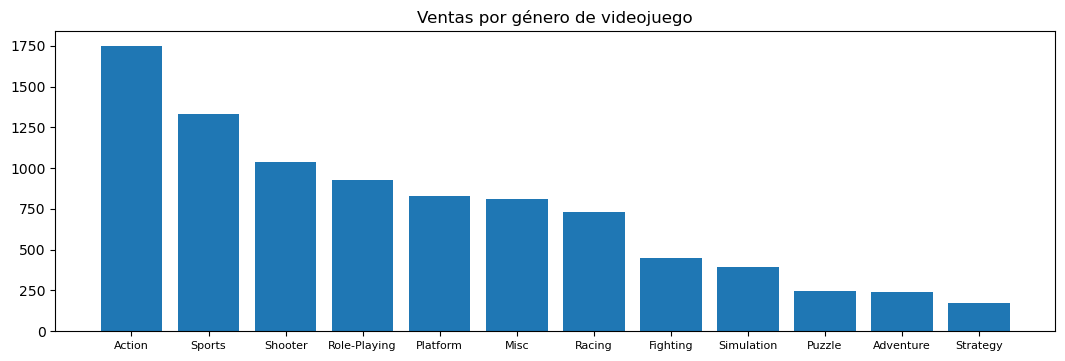

In [56]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_axes([0,0,1,1])
ventas = sales_genero['ventas_total']
generos = sales_genero['genre']
ax.set_title('Ventas por género de videojuego')
ax.bar(generos, ventas)
ax.tick_params(axis='x', labelsize=8)
plt.show()

#### Promedio de ventas, ventas totales y participación de mercado por plataforma de videojuego 

In [57]:
sql_query2 = '''SELECT p.platform,round(AVG(f.global_sales)::numeric,4) as Mean_Sales, round(sum(f.global_sales)::numeric, 2) as Ventas_totales, round((sum(f.global_sales) / (SELECT sum(global_sales) from fact_sales))::NUMERIC,3) as participacion
                FROM fact_sales AS f
                LEFT JOIN dim_plataforma AS p
                ON f.id_plataforma=p.id_plataforma
                GROUP BY p.platform
                ORDER BY Ventas_totales DESC'''
mean_platform = pd.read_sql(sql_query2, postgres_driver)
mean_platform

,platform,mean_sales,ventas_totales,participacion
0,PS2,0.5810,1255.64,0.141
1,X360,0.7747,979.96,0.110
2,PS3,0.7207,957.84,0.107
3,Wii,0.6994,926.71,0.104
4,DS,0.3803,822.49,0.092
5,PS,0.6109,730.66,0.082
6,GBA,0.3875,318.50,0.036
7,PSP,0.2443,296.28,0.033
8,PS4,0.8277,278.10,0.031
9,PC,0.2696,258.82,0.029


Se obtiene el top 10 de las plataformas según sus ventas

In [58]:
top10_plat = mean_platform.head(10)
print(top10_plat)

  platform  mean_sales  ventas_totales  participacion
0      PS2      0.5810         1255.64          0.141
1     X360      0.7747          979.96          0.110
2      PS3      0.7207          957.84          0.107
3      Wii      0.6994          926.71          0.104
4       DS      0.3803          822.49          0.092
5       PS      0.6109          730.66          0.082
6      GBA      0.3875          318.50          0.036
7      PSP      0.2443          296.28          0.033
8      PS4      0.8277          278.10          0.031
9       PC      0.2696          258.82          0.029


Se grafican los datos para determinar su participación dentro del top 10

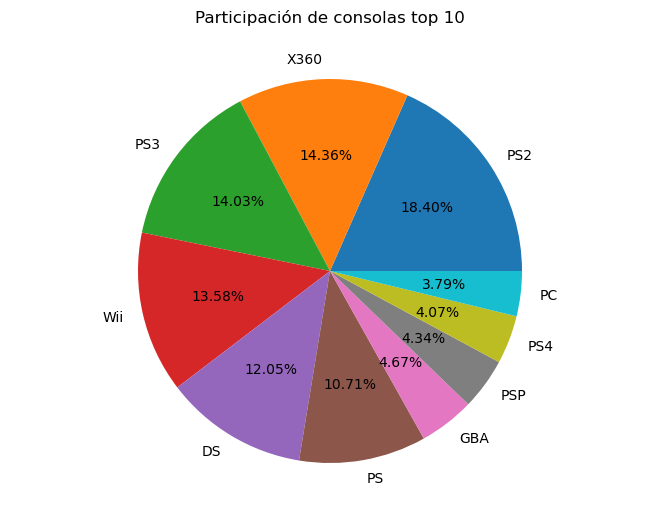

In [59]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.axis('equal')
particip = top10_plat['ventas_totales']
consolas = top10_plat['platform']
ax.set_title('Participación de consolas top 10')
ax.pie(particip, labels=consolas, autopct='%1.2f%%')
plt.show()

#### Ventas Globales por rango de años de videojuego

In [60]:
sql_query = '''SELECT y.category_year,sum(f.global_sales) as Ventas_Total
                FROM fact_sales AS f
                LEFT JOIN dim_year AS y
                ON f.year=y.year
                GROUP BY y.category_year
                ORDER BY Ventas_Total DESC'''
sales_year = pd.read_sql(sql_query, postgres_driver)
sales_year

,category_year,ventas_total
0,2000-2009,4644.02
1,2010-2019,2520.56
2,1990-1999,1278.91
3,1980-1989,376.58
4,Unknown,100.08
5,2020-2029,0.29


#### Ventas globales y región por Publisher de video juego

In [61]:
sql_query = '''SELECT p.publisher, round(sum(f.na_sales)::numeric, 2) as Ventas_NA, round(sum(f.EU_Sales)::NUMERIC, 2) as Ventas_EU, round(sum(f.JP_Sales)::NUMERIC, 2) as Ventas_JP,round(sum(f.global_sales)::NUMERIC,2) as Ventas_Total
                FROM fact_sales AS f
                LEFT JOIN dim_publisher AS p
                ON p.ID_Publisher=f.ID_Publisher
                GROUP BY p.publisher
                ORDER BY Ventas_Total DESC'''
sales_publisher = pd.read_sql(sql_query, postgres_driver)
sales_publisher

,publisher,ventas_na,ventas_eu,ventas_jp,ventas_total
0,Nintendo,816.87,418.74,455.42,1786.56
1,Electronic Arts,595.07,371.27,14.04,1110.32
2,Activision,429.70,215.53,6.54,727.46
3,Sony Computer Entertainment,265.22,187.72,74.10,607.50
4,Ubisoft,253.43,163.32,7.50,474.72
...,...,...,...,...,...
574,Boost On,0.00,0.00,0.01,0.01
575,EON Digital Entertainment,0.01,0.00,0.00,0.01
576,Ascaron Entertainment,0.00,0.01,0.00,0.01
577,"Interworks Unlimited, Inc.",0.01,0.00,0.00,0.01


Se grafica la distribución del top 5 y sus ventas

<AxesSubplot:title={'center':'Ventas publicador y región'}, xlabel='publisher'>

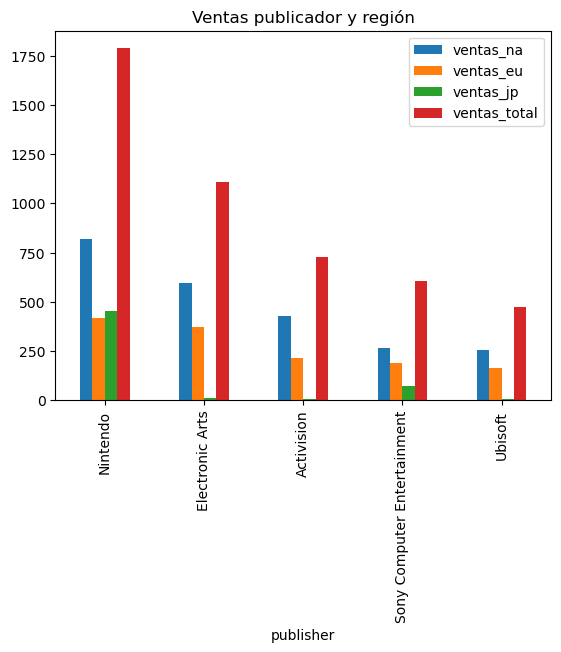

In [62]:
data=sales_publisher.head()
data.plot(x='publisher', y=['ventas_na', 'ventas_eu', 'ventas_jp', 'ventas_total'], kind= 'bar', title='Ventas publicador y región')

#### Ventas por videojuego

In [63]:
sql_query = '''SELECT pr.name, cast (f.year as int), round(sum(f.global_sales)::NUMERIC,2) as Ventas_Total
                FROM fact_sales AS f
                LEFT JOIN dim_product AS pr
                ON f.ID_Product=pr.ID_Product
                GROUP BY f.year, pr.name
                ORDER BY Ventas_Total DESC'''
sales_name = pd.read_sql(sql_query, postgres_driver)
sales_name

,name,year,ventas_total
0,Wii Sports,2006,82.74
1,Super Mario Bros.,1985,40.24
2,Grand Theft Auto V,2013,37.78
3,Mario Kart Wii,2008,35.82
4,Wii Sports Resort,2009,33.00
...,...,...,...
12358,Resistance Dual Pack,2011,0.01
12359,Rosario to Vampire: Tanabata no Miss Youkai Ga...,2008,0.01
12360,Smart Boy's Winter Wonderland,2008,0.01
12361,Dr. Slump & Arale-Chan,2008,0.01
